# 1ª Baseline LSTM
## Steps
### 1 - Evaluate the similarity between signals
### 2 - To build and train a recurrent neural network model to extract the features of the EEG segment with  70% similarity or higher
### 3 - To build another recurrent neural network model, transfer the learned parameters from the EEG segments, and process the target domain

# Imports

In [5]:
# !pip install pandas pyarrow tensorflow h5py 

# !pip install numpy --upgrade --user

# !pip install tensorflow --upgrade --user

# !pip install keras --upgrade --user

# !pip install dtw-python

# !pip install scipy

# !pip install plot_keras_history

# !pip install matplotlib

# !pip install scikit-learn

In [6]:
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from scipy import signal
import tensorflow as tf
import pyarrow as pa
import pandas as pd
import numpy as np
import scipy.fft 
import datetime
import keras
import glob
import os


from keras.layers import LSTM, Bidirectional, Dense, Dropout, Flatten, BatchNormalization
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from plot_keras_history import show_history, plot_history
from keras.models import Sequential, model_from_json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
from keras.callbacks import Callback
from keras.utils import plot_model
from pandas import DataFrame
from pandas import concat
from pathlib import Path
from dtw import *

# Variables

In [7]:
root_data_eeg_path = Path(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/10_sec/')
root_data_ecg_path = Path(r'/media/s792288955/TOSHIBA EXT/Andrea/Kaggle/ECG-Dataset/')
root_data_emg_path = Path(r'/media/s792288955/TOSHIBA EXT/Andrea/Kaggle/ClassifyGestures_EMG/')

scaler = MinMaxScaler(feature_range=(0, 1))
SEED = 1957
learning_rate = 0.001
n_features = 4
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2

ecg_fs = 125  # frequency in Hz
ecg_lowcut = 0.5  # low frequency in Hz
ecg_highcut = 40  # hight frequency in Hz
ecg_window_length = 20
ecg_polyorder = 5

emg_fs = 200  # frequency in Hz
emg_lowcut = 0.15  # low frequency in Hz
emg_highcut = 40  # hight frequency in Hz
emg_window_length = 20
emg_polyorder = 5

# Datasets

In [8]:
# EEG

# 15 seconds
df_data_eeg_ori_v1_01_tcp_ar = pd.read_parquet(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/15_sec/v1_1_0_01_tcp_ar.parquet')
df_data_eeg_ori_v1_02_tcp_le = pd.read_parquet(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/15_sec/v1_1_0_02_tcp_le.parquet')
df_data_eeg_ori_v1_03_tcp_ar_a = pd.read_parquet(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/15_sec/v1_1_0_03_tcp_ar_a.parquet')
df_data_eeg_ori_v1_04_tcp_le_a = pd.read_parquet(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/15_sec/v1_1_0_04_tcp_le_a.parquet')

df_data_eeg_ori_v2_01_tcp_ar = pd.read_parquet(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/15_sec/v1_2_0_01_tcp_ar.parquet')
df_data_eeg_ori_v2_03_tcp_ar_a = pd.read_parquet(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/15_sec/v1_2_0_03_tcp_ar_a.parquet')

df_data_eeg_ori = pd.concat([df_data_eeg_ori_v1_01_tcp_ar, 
                             df_data_eeg_ori_v1_02_tcp_le,
                             df_data_eeg_ori_v1_03_tcp_ar_a, 
                             df_data_eeg_ori_v1_04_tcp_le_a,
                             df_data_eeg_ori_v2_01_tcp_ar, 
                             df_data_eeg_ori_v2_03_tcp_ar_a])

In [9]:
#ECG
df_data_ecg_train = pd.read_csv(r'/media/s792288955/TOSHIBA EXT/Andrea/Kaggle/ECG-Dataset/mitbih_train.csv',
                          sep=',', header=None)

df_data_ecg_abnormal = pd.read_csv(r'/media/s792288955/TOSHIBA EXT/Andrea/Kaggle/ECG-Dataset/ptbdb_abnormal.csv',
                          sep=',', header=None)

df_data_ecg_normal = pd.read_csv(r'/media/s792288955/TOSHIBA EXT/Andrea/Kaggle/ECG-Dataset/ptbdb_normal.csv',
                          sep=',', header=None)


df_data_ecg_train_ori = pd.concat([df_data_ecg_train, df_data_ecg_abnormal, df_data_ecg_normal], axis=0)

df_data_ecg_test_ori = pd.read_csv(r'/media/s792288955/TOSHIBA EXT/Andrea/Kaggle/ECG-Dataset/mitbih_test.csv',
                          sep=',', header=None)


In [10]:
#EMG
all_filenames = [i for i in root_data_emg_path.glob('*.{}'.format('csv'))]

df_data_emg_0_ori = pd.read_csv(all_filenames[0], 
                                sep=",", header=None)

df_data_emg_1_ori = pd.read_csv(all_filenames[1], 
                                sep=",", header=None)

df_data_emg_2_ori = pd.read_csv(all_filenames[2], 
                                 sep=",", header=None)

df_data_emg_3_ori = pd.read_csv(all_filenames[3], 
                                   sep=",", header=None)

df_data_emg_ori   = pd.concat([df_data_emg_0_ori,df_data_emg_1_ori,df_data_emg_2_ori,df_data_emg_3_ori], axis=0)


# Preprocessing

### EEG

In [11]:
# Split into X and Y
X_train_eeg_ori = df_data_eeg_ori[["A2", "F3", "F4", "F7", "F8", "FP1", "FP2", "FZ", 
                                   "T3", "T4", "T5", "T6", "C3", "C4", "CZ", "O1", 
                                   "O2", "P3", "P4", "PZ"]].copy()

y_train_eeg_ori = df_data_eeg_ori['id_diagnose'].copy()

print(X_train_eeg_ori.shape)
print(y_train_eeg_ori.shape)

(412400, 20)
(412400,)


In [12]:
X_train_eeg, X_test_eeg, y_train_eeg, y_test_eeg = train_test_split(X_train_eeg_ori, 
                                                                    y_train_eeg_ori, 
                                                                    train_size=0.8, random_state=None)

print(X_train_eeg.shape)
print(y_train_eeg.shape)
print(X_test_eeg.shape)
print(y_test_eeg.shape)

(329920, 20)
(329920,)
(82480, 20)
(82480,)


In [13]:
# Encode the unique values in the target
unique_train_eeg, counts_train_eeg = np.unique(y_train_eeg, return_counts = True)
print(f'Unique eeg train dependent values: {unique_train_eeg}')
print(f'counts eeg train depentent values: {counts_train_eeg}')

unique_test_eeg, counts_test_eeg = np.unique(y_test_eeg, return_counts = True)
print(f'Unique EEG test dependent values: {unique_test_eeg}')
print(f'counts EEG test depentent values: {counts_test_eeg}')

# Dictionary to map the target indices to class names
class_eeg_names = {1: 'Normal', 2: 'Abnormal', 3: 'Seizure', 10: 'Not Informed'}

# The input dims are 20
X_train_eeg_np = X_train_eeg.to_numpy()
y_train_eeg_np = y_train_eeg.to_numpy()

X_test_eeg_np = X_test_eeg.to_numpy()
y_test_eeg_np = y_test_eeg.to_numpy()

# Add a channel dimension to the input
X_train_eeg_np = X_train_eeg_np.reshape(-1, 1, 20)
y_train_eeg = y_train_eeg_np.reshape(-1, 1)

X_test_eeg_np = X_test_eeg_np.reshape(-1, 1, 20)
y_test_eeg = y_test_eeg_np.reshape(-1, 1)

print("X_train_eeg_np = ", X_train_eeg_np.shape)
print("y_train_eeg_np = ", y_train_eeg_np.shape)

print("X_test_eeg_np = ", X_test_eeg_np.shape)
print("y_test_eeg_np = ", y_test_eeg_np.shape)

Unique eeg train dependent values: [ 1  2  3 10]
counts eeg train depentent values: [ 71478 213299  36483   8660]
Unique EEG test dependent values: [ 1  2  3 10]
counts EEG test depentent values: [17754 53437  9085  2204]
X_train_eeg_np =  (329920, 1, 20)
y_train_eeg_np =  (329920,)
X_test_eeg_np =  (82480, 1, 20)
y_test_eeg_np =  (82480,)


In [14]:
# Do not need to remove noise

In [15]:
# Fourier Transforms (FFTs) to work in frequency domain.
X_train_eeg_freq  = scipy.fft.fft2(X_train_eeg_np).view(np.float64)
X_test_eeg_freq  = scipy.fft.fft2(X_test_eeg_np).view(np.float64)

In [16]:
# Normalizing the amplitude values to the range of between zero and one.
scaler_eeg = MinMaxScaler()

X_train_eeg_freq = X_train_eeg_freq.reshape(X_train_eeg_freq.shape[0], -1)
X_train_eeg_freq = scaler_eeg.fit_transform(X_train_eeg_freq)

X_test_eeg_freq = X_test_eeg_freq.reshape(X_test_eeg_freq.shape[0], -1)
X_test_eeg_freq = scaler_eeg.fit_transform(X_test_eeg_freq)

# Reshape
X_train_eeg_freq = X_train_eeg_freq.reshape(-1, 1, 40)
X_test_eeg_freq = X_test_eeg_freq.reshape(-1, 1, 40)

In [17]:
print(X_train_eeg_freq.shape)
print(y_train_eeg_np.shape)

print(X_test_eeg_freq.shape)
print(y_test_eeg_np.shape)

(329920, 1, 40)
(329920,)
(82480, 1, 40)
(82480,)


### ECG

In [18]:
# split into input and outputs
X_train_ecg_ori = df_data_ecg_train_ori.iloc[:, 160:180].copy()
y_train_ecg = df_data_ecg_train_ori.iloc[:, -1].copy()

X_test_ecg_ori = df_data_ecg_test_ori.iloc[:,  160:180].copy()
y_test_ecg = df_data_ecg_test_ori.iloc[:, -1].copy()

# ensure all data is float
X_train_ecg_ori = X_train_ecg_ori.astype('float64')
print("X_train_ecg =", X_train_ecg_ori.shape)

y_train_ecg = y_train_ecg.astype('int64')
print("y_train_ecg = ",y_train_ecg.shape)

# ensure all data is int
X_test_ecg_ori = X_test_ecg_ori.astype('float64')
print("X_test_ecg =", X_test_ecg_ori.shape)

y_test_ecg = y_test_ecg.astype('int64')
print("y_test_ecg = ",y_test_ecg.shape)


X_train_ecg = (102106, 20)
y_train_ecg =  (102106,)
X_test_ecg = (21892, 20)
y_test_ecg =  (21892,)


In [19]:
# Encode the unique values in the target
unique_train_ecg, counts_train_ecg = np.unique(y_train_ecg, return_counts = True)
print(f'Unique ECG train dependent values: {unique_train_ecg}')
print(f'counts ECG train depentent values: {counts_train_ecg}')

unique_test_ecg, counts_test_ecg = np.unique(y_test_ecg, return_counts = True)
print(f'Unique ECG test dependent values: {unique_test_ecg}')
print(f'counts ECG test depentent values: {counts_test_ecg}')

# Dictionary to map the target indices to class names
# 0: 'Normal', 1: 'Atrial Premature', 2: 'Ventricular Premature',3: 'Fusion Ventricular', 4: 'Unclissifiable'
class_ecg_names = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

#
X_train_ecg_np = X_train_ecg_ori.to_numpy()
y_train_ecg_np = y_train_ecg.to_numpy()

X_test_ecg_np = X_test_ecg_ori.to_numpy()
y_test_ecg_np = y_test_ecg.to_numpy()


X_train_ecg_np = X_train_ecg_np.reshape(-1, 1, 20)
y_train_ecg = y_train_ecg_np.reshape(-1, 1)

X_test_ecg_np = X_test_ecg_np.reshape(-1, 1, 20)
y_test_ecg = y_test_ecg_np.reshape(-1, 1)


print("X_train_ecg_np = ", X_train_ecg_np.shape)
print("y_train_ecg_np = ", y_train_ecg.shape)

print("X_test_ecg_np = ", X_test_ecg_np.shape)
print("y_test_ecg_np = ", y_test_ecg.shape)

Unique ECG train dependent values: [0 1 2 3 4]
counts ECG train depentent values: [76517 12729  5788   641  6431]
Unique ECG test dependent values: [0 1 2 3 4]
counts ECG test depentent values: [18118   556  1448   162  1608]
X_train_ecg_np =  (102106, 1, 20)
y_train_ecg_np =  (102106, 1)
X_test_ecg_np =  (21892, 1, 20)
y_test_ecg_np =  (21892, 1)


In [20]:
# remove low and high noise frequecy
ecg_b, ecg_a = signal.butter(4, [ecg_lowcut / (ecg_fs/2), ecg_highcut / (ecg_fs/2)], 'band')
X_train_ecg_filtered = signal.filtfilt(ecg_b, ecg_a, X_train_ecg_np, padlen=X_train_ecg_np.shape[2]-1)
X_test_ecg_filtered = signal.filtfilt(ecg_b, ecg_a, X_test_ecg_np, padlen=X_test_ecg_np.shape[2]-1)

# Apply moving average to remove high noise
X_train_ecg_filtered = signal.savgol_filter(X_train_ecg_filtered, ecg_window_length, ecg_polyorder)
X_test_ecg_filtered = signal.savgol_filter(X_test_ecg_filtered, ecg_window_length, ecg_polyorder)

In [21]:
# Fourier Transforms (FFTs) to work in frequency domain.
X_train_ecg_freq  = scipy.fft.fft2(X_train_ecg_filtered).view(np.float64)
X_test_ecg_freq  = scipy.fft.fft2(X_test_ecg_filtered).view(np.float64)

In [22]:
# Normalizing the amplitude values to the range of between zero and one.
scaler_ecg = MinMaxScaler()

X_train_ecg_freq = X_train_ecg_freq.reshape(X_train_ecg_freq.shape[0], -1)
X_train_ecg_freq = scaler_ecg.fit_transform(X_train_ecg_freq)

X_test_ecg_freq = X_test_ecg_freq.reshape(X_test_ecg_freq.shape[0], -1)
X_test_ecg_freq = scaler_ecg.fit_transform(X_test_ecg_freq)

# Reshape
X_train_ecg_freq = X_train_ecg_freq.reshape(-1, 1, 40)
X_test_ecg_freq = X_test_ecg_freq.reshape(-1, 1, 40)

In [23]:
print(X_train_ecg_freq.shape)
print(X_test_ecg_freq.shape)

(102106, 1, 40)
(21892, 1, 40)


### EMG

In [24]:
# Split into X and Y
X_emg_ori = df_data_emg_ori.iloc[:, 20:40].copy()
y_emg_ori = df_data_emg_ori.iloc[:,-1].copy()

# emg_1 = df_data_emg_ori[:,   :20].copy()
# emg_2 = df_data_emg_ori[:,  20:40].copy()
# emg_3 = df_data_emg_ori[:,  40:60].copy()



print(X_emg_ori.shape)
print(y_emg_ori.shape)

(11678, 20)
(11678,)


In [25]:
# Now, train test split
X_train_emg, X_test_emg, y_train_emg, y_test_emg = train_test_split(X_emg_ori, y_emg_ori, train_size=0.8)

print(X_train_emg.shape)
print(y_train_emg.shape)
print(X_test_emg.shape)
print(y_test_emg.shape)

(9342, 20)
(9342,)
(2336, 20)
(2336,)


In [26]:
# Encode the unique values in the target
unique_train_emg, counts_train_emg = np.unique(y_train_emg, return_counts = True)
print(f'Unique EMG train dependent values: {unique_train_emg}')
print(f'counts EMG train depentent values: {counts_train_emg}')

unique_test_emg, counts_test_emg = np.unique(y_test_emg, return_counts = True)
print(f'Unique EMG test dependent values: {unique_test_emg}')
print(f'counts EMG test depentent values: {counts_test_emg}')

# Dictionary to map the target indices to class names
class_emg_names = {0: 'Rock', 1: 'Scissors', 2: 'Paper', 3: 'Ok'}

# Transform data in numpu number
X_train_emg_np = X_train_emg.to_numpy()
y_train_emg_np = y_train_emg.to_numpy()

X_test_emg_np = X_test_emg.to_numpy()
y_test_emg_np = y_test_emg.to_numpy()

# Add a channel dimension to the input
X_train_emg_np = X_train_emg_np.reshape(-1, 1, 20)
y_train_emg = y_train_emg_np.reshape(-1, 1)

X_test_emg_np = X_test_emg_np.reshape(-1, 1, 20)
y_test_emg = y_test_emg_np.reshape(-1, 1)

print("X_train_emg_np = ", X_train_emg_np.shape)
print("y_train_emg_np = ", y_train_emg_np.shape)

print("X_test_emg_np = ", X_test_emg_np.shape)
print("y_test_emg_np = ", y_test_emg_np.shape)



Unique EMG train dependent values: [0 1 2 3]
counts EMG train depentent values: [2364 2332 2318 2328]
Unique EMG test dependent values: [0 1 2 3]
counts EMG test depentent values: [546 571 625 594]
X_train_emg_np =  (9342, 1, 20)
y_train_emg_np =  (9342,)
X_test_emg_np =  (2336, 1, 20)
y_test_emg_np =  (2336,)


In [27]:
# signal.butter - Design an Nth-order digital or analog Butterworth filter and return the filter coefficients.
emg_b, emg_a = signal.butter(4, [emg_lowcut / (emg_fs/2), emg_highcut / (emg_fs/2)], 'band')
X_train_emg_filtered = signal.filtfilt(emg_b, emg_a, X_train_emg_np, padlen=X_train_emg_np.shape[2]-1)
X_test_emg_filtered = signal.filtfilt(emg_b, emg_a, X_test_emg_np, padlen=X_test_emg_np.shape[2]-1)

# Apply moving average to remove high noise
X_train_emg_filtered = signal.savgol_filter(X_train_emg_filtered, emg_window_length, emg_polyorder)
X_test_emg_filtered = signal.savgol_filter(X_test_emg_filtered, emg_window_length, emg_polyorder)

In [28]:
print(X_train_emg_filtered.shape)
print(X_test_emg_filtered.shape)


(9342, 1, 20)
(2336, 1, 20)


In [29]:
# Fourier Transforms (FFTs) to work in frequency domain.
X_train_emg_freq  = scipy.fft.fft2(X_train_emg_filtered).view(np.float64)
X_test_emg_freq  = scipy.fft.fft2(X_test_emg_filtered).view(np.float64)


In [30]:
print(X_train_emg_freq.shape)
print(y_train_emg.shape)

print(X_test_emg_freq.shape)
print(y_test_emg.shape)

(9342, 1, 40)
(9342, 1)
(2336, 1, 40)
(2336, 1)


In [31]:
# Normalizing the amplitude values to the range of between zero and one.
scaler_emg = MinMaxScaler()

X_train_emg_freq = X_train_emg_freq.reshape(X_train_emg_freq.shape[0], -1)
X_train_emg_freq = scaler_emg.fit_transform(X_train_emg_freq)

X_test_emg_freq = X_test_emg_freq.reshape(X_test_emg_freq.shape[0], -1)
X_test_emg_freq = scaler_emg.fit_transform(X_test_emg_freq)


# Add a channel dimension to the input
X_train_emg_freq = X_train_emg_freq.reshape(-1, 1, 40)
X_test_emg_freq = X_test_emg_freq.reshape(-1, 1, 40)

In [32]:
print(X_train_emg_freq.shape)
print(y_train_emg.shape)

print(X_test_emg_freq.shape)
print(y_test_emg.shape)

(9342, 1, 40)
(9342, 1)
(2336, 1, 40)
(2336, 1)


# Baseline LSTM Process

## Steps

### 1 - Train and test ECG model
### 2 - Train and test EMG model
### 3 - Train and test EEG model

20 - 50 - 100 - 150 - 200 - 300 - 400

In [12]:
epochs = 50

### 1 - ECG train and test model

In [13]:
# Model from https://github.com/federicohyo/lstm-ecg
model_ecg_lstm = Sequential()

model_ecg_lstm.add(Bidirectional(LSTM(X_train_ecg_freq.shape[2], return_sequences=True,
                                      input_shape=(X_train_ecg_freq.shape[1], X_train_ecg_freq.shape[2]))))

model_ecg_lstm.add(LSTM(256, return_sequences=True))
model_ecg_lstm.add(Dropout(0.2))

model_ecg_lstm.add(LSTM(128, return_sequences=True))
model_ecg_lstm.add(Dropout(0.2))

model_ecg_lstm.add(LSTM(64, return_sequences=True))
model_ecg_lstm.add(Dropout(0.2))

model_ecg_lstm.add(LSTM(32, return_sequences=True))
model_ecg_lstm.add(Dropout(0.2))

model_ecg_lstm.add(LSTM(16, return_sequences=True))

model_ecg_lstm.add(Dense(1, activation='sigmoid'))


In [14]:
model_ecg_lstm.build(X_train_ecg_freq.shape)

In [15]:
model_ecg_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (102106, 1, 80)           25920     
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (102106, 1, 256)          345088    
                                                                 
 dropout (Dropout)           (102106, 1, 256)          0         
                                                                 
 lstm_2 (LSTM)               (102106, 1, 128)          197120    
                                                                 
 dropout_1 (Dropout)         (102106, 1, 128)          0         
                                                                 
 lstm_3 (LSTM)               (102106, 1, 64)           49408     
                                                        

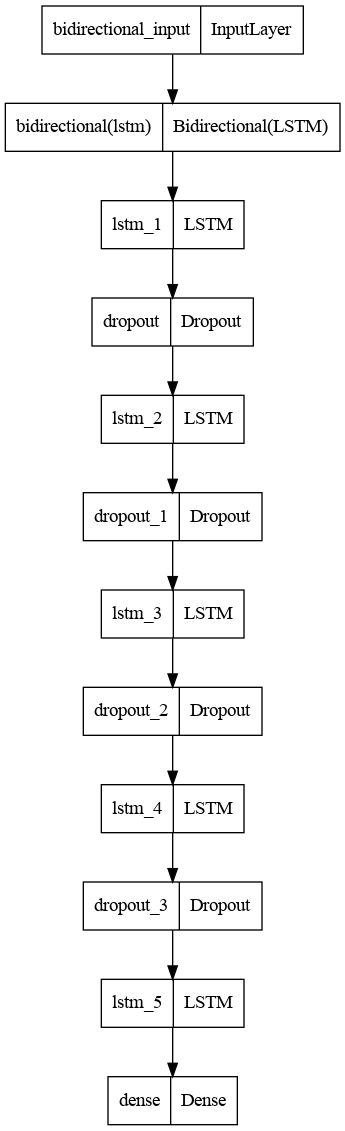

In [16]:
#Save the Summary's plan

path_model_ecg_lstm_summary = "./images/Santos2022_Baseline_ECG_G9_Summary_FINAL.png"

plot_model(model_ecg_lstm, to_file=path_model_ecg_lstm_summary)


In [17]:
#Callbacks instructions

#Peform visualization
    #1 - Open cmd, go to the folder where this file is;
    #2 - set the command: tensorboard --logdir logs/fit
    #3 - Copy the link (http://localhost:6006/) in browser  

log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_ecg_lstm_tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Save the best performance
checkpoint_filepath = "./checkpoint_bline_ecg"

model_ecg_lstm_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath = checkpoint_filepath,
                                                                     save_weights_only = False, #Save the model and weights
                                                                     monitor = "val_accuracy",
                                                                     mode = "max",
                                                                     save_best_only = True,
                                                                     initial_value_theshold = True)

#Early stop when a error occour
model_ecg_lstm_earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                 patience=5,
                                                                 restore_best_weights=True)

In [18]:
# Model from https://github.com/federicohyo/lstm-ecg

adam_ecg = keras.optimizers.legacy.Adam(learning_rate=learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-08, 
                                     decay=0.0)

model_ecg_lstm.compile(optimizer=adam_ecg, 
                   loss="mean_squared_error", 
                   metrics=["accuracy", 
                            tf.keras.metrics.MeanSquaredError(), 
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.PrecisionAtRecall(0.5)]
                       )

In [19]:
# suffle = False -  (dont allow mix the data )

# Train - (102106, 1, 40) / Test - (21892, 1, 40)
ecg_train_batch_size = 11000 
ecg_test_batch_size  = 2200 

history_ecg = model_ecg_lstm.fit(X_train_ecg_freq, 
                                 y_train_ecg, 
                                 validation_split=0.2, 
                                 epochs=epochs, 
                                 batch_size=ecg_train_batch_size,
                                 shuffle=False,
                                 callbacks=[model_ecg_lstm_tensorboard_callback, 
                                            model_ecg_lstm_checkpoint_callback] )

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.7876 - mean_squared_error: 0.5210 - root_mean_squared_error: 0.7218 - precision: 0.0000e+00 - recall: 0.0000e+00 - precision_at_recall: 0.1128  INFO:tensorflow:Assets written to: ./checkpoint_bline_ecg/assets


INFO:tensorflow:Assets written to: ./checkpoint_bline_ecg/assets


8/8 [==============================] - 21s 2s/step - loss: 0.5210 - accuracy: 0.7876 - mean_squared_error: 0.5210 - root_mean_squared_error: 0.7218 - precision: 0.0000e+00 - recall: 0.0000e+00 - precision_at_recall: 0.1128 - val_loss: 3.7121 - val_accuracy: 0.1981 - val_mean_squared_error: 3.7121 - val_root_mean_squared_error: 1.9267 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision_at_recall: 0.8019
Epoch 2/50
8/8 [==============================] - 2s 267ms/step - loss: 0.5183 - accuracy: 0.8872 - mean_squared_error: 0.5183 - root_mean_squared_error: 0.7199 - precision: 0.0000e+00 - recall: 0.0000e+00 - precision_at_recall: 0.1128 - val_loss: 3.7158 - val_accuracy: 0.1981 - val_mean_squared_error: 3.7158 - val_root_mean_squared_error: 1.9276 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision_at_recall: 0.8019
Epoch 3/50
8/8 [==============================] - 2s 292ms/step - loss: 0.5174 - accuracy: 0.8872 - mean_squared_error: 0.5174 - root_mean_sq

Epoch 20/50
8/8 [==============================] - 3s 334ms/step - loss: 0.4883 - accuracy: 0.8872 - mean_squared_error: 0.4883 - root_mean_squared_error: 0.6988 - precision: 0.0000e+00 - recall: 0.0000e+00 - precision_at_recall: 0.1128 - val_loss: 3.8919 - val_accuracy: 0.1981 - val_mean_squared_error: 3.8919 - val_root_mean_squared_error: 1.9728 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision_at_recall: 0.8025
Epoch 21/50
8/8 [==============================] - 3s 342ms/step - loss: 0.4858 - accuracy: 0.8872 - mean_squared_error: 0.4858 - root_mean_squared_error: 0.6970 - precision: 0.0000e+00 - recall: 0.0000e+00 - precision_at_recall: 0.1128 - val_loss: 3.9062 - val_accuracy: 0.1981 - val_mean_squared_error: 3.9062 - val_root_mean_squared_error: 1.9764 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision_at_recall: 0.8026
Epoch 22/50
8/8 [==============================] - 3s 352ms/step - loss: 0.4836 - accuracy: 0.8872 - mean_squared_error: 0.483

Epoch 39/50
8/8 [==============================] - 3s 346ms/step - loss: 0.4711 - accuracy: 0.8872 - mean_squared_error: 0.4711 - root_mean_squared_error: 0.6864 - precision: 0.0000e+00 - recall: 0.0000e+00 - precision_at_recall: 0.1128 - val_loss: 3.9888 - val_accuracy: 0.1981 - val_mean_squared_error: 3.9888 - val_root_mean_squared_error: 1.9972 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision_at_recall: 0.8020
Epoch 40/50
8/8 [==============================] - 3s 343ms/step - loss: 0.4711 - accuracy: 0.8872 - mean_squared_error: 0.4711 - root_mean_squared_error: 0.6863 - precision: 0.0000e+00 - recall: 0.0000e+00 - precision_at_recall: 0.1128 - val_loss: 3.9897 - val_accuracy: 0.1981 - val_mean_squared_error: 3.9897 - val_root_mean_squared_error: 1.9974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision_at_recall: 0.8021
Epoch 41/50
8/8 [==============================] - 3s 337ms/step - loss: 0.4709 - accuracy: 0.8872 - mean_squared_error: 0.470

In [ ]:
# list all data in history
# print(history_ecg.history.keys())
# path_his_ecg = "History_ECG_Train__g9" + str(epochs) + "epochs_FINAL.png"

# # summarize history for accuracy
# show_history(history_ecg)
# plot_history(history_ecg)
# plot_history(history_ecg, path=path_his_ecg)
# plt.close()

In [26]:
#Evaluate's ECG model for train dataset

scores_train_ecg = model_ecg_lstm.evaluate(x = X_train_ecg_freq, 
                                           y = y_train_ecg, 
                                           batch_size = ecg_train_batch_size, 
                                           verbose = 1)

print("Train - ECG Signal")
print("Train %s: %.2f%%" % (model_ecg_lstm.metrics_names[0].upper(), scores_train_ecg[0]*100))
print("Train %s: %.2f" % (model_ecg_lstm.metrics_names[1].upper(), scores_train_ecg[1]*100))
print("Train %s: %.2f" % (model_ecg_lstm.metrics_names[2].upper(), scores_train_ecg[2]))
print("Train %s: %.2f" % (model_ecg_lstm.metrics_names[3].upper(), scores_train_ecg[3]))
print("Train %s: %.2f%%" % (model_ecg_lstm.metrics_names[4].upper(), scores_train_ecg[4]*100))
print("Train %s: %.2f%%" % (model_ecg_lstm.metrics_names[5].upper(), scores_train_ecg[5]*100))
print("Train %s: %.2f" % (model_ecg_lstm.metrics_names[6].upper(), scores_train_ecg[6]*100))

10/10 [==============================] - 1s 112ms/step - loss: 1.1735 - accuracy: 0.7494 - mean_squared_error: 1.1735 - root_mean_squared_error: 1.0833 - precision: 0.0000e+00 - recall: 0.0000e+00 - precision_at_recall: 0.2506
Train - ECG Signal
Train LOSS: 117.35%
Train ACCURACY: 74.94
Train MEAN_SQUARED_ERROR: 1.17
Train ROOT_MEAN_SQUARED_ERROR: 1.08
Train PRECISION: 0.00%
Train RECALL: 0.00%
Train PRECISION_AT_RECALL: 25.06


In [ ]:
#Evaluate's ECG model for test dataset

score_test_ecg = model_ecg_lstm.evaluate(x = X_test_ecg_freq, 
                                         y = y_test_ecg, 
                                         batch_size = ecg_test_batch_size, 
                                         verbose = 1)

print("Test - ECG Signal")
print("Test %s: %.4f%%" % (model_ecg_lstm.metrics_names[0].upper(), score_test_ecg[0]*100))
print("Test %s: %.4f%%" % (model_ecg_lstm.metrics_names[1].upper(), score_test_ecg[1]*100))
print("Test %s: %.4f%%" % (model_ecg_lstm.metrics_names[2].upper(), score_test_ecg[2]*100))
print("Test %s: %.4f%%" % (model_ecg_lstm.metrics_names[3].upper(), score_test_ecg[3]*100))
print("Test %s: %.4f%%" % (model_ecg_lstm.metrics_names[4].upper(), score_test_ecg[4]*100))
print("Test %s: %.4f%%" % (model_ecg_lstm.metrics_names[5].upper(), score_test_ecg[5]*100))
print("Test %s: %.4f%%" % (model_ecg_lstm.metrics_names[6].upper(), score_test_ecg[6]*100))

In [ ]:
# # #DONT ERASE this code

path_json_ecg = "model_bl_lstm_ecg_g9_20features_" + str(epochs) + "epochs_FINAL.json"
path_weights_ecg = "model_bl_lstm_weights_ecg_g9_20features_" + str(epochs) + "epochs_FINAL.h5"

#Serialize model to json
model_ecg_lstm_json = model_ecg_lstm.to_json()
with open("./model_weights/" + path_json_ecg, "w") as json_file:
    json_file.write(model_ecg_lstm_json)
    
#Serialize weights to HDF5
model_ecg_lstm.save_weights("./model_weights/" + path_weights_ecg)

print("ECG Model and Weights saved on the disk.")

### 2 - EMG train and test model

In [36]:
model_emg_lstm = Sequential()

model_emg_lstm.add(LSTM(X_train_emg_freq.shape[2], return_sequences=True,
                                      input_shape=(X_train_emg_freq.shape[1], X_train_emg_freq.shape[2])))


model_emg_lstm.add(LSTM(128, return_sequences=True))
model_emg_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
model_emg_lstm.add(Dropout(0.2))

model_emg_lstm.add(LSTM(64, return_sequences=True))
model_emg_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_emg_lstm.add(Dropout(0.2))

model_emg_lstm.add(LSTM(32, return_sequences=True))
model_emg_lstm.add(Bidirectional(LSTM(32, return_sequences=True)))
model_emg_lstm.add(Dropout(0.2))

model_emg_lstm.add(LSTM(16, return_sequences=True))
model_emg_lstm.add(Bidirectional(LSTM(16, return_sequences=True)))

model_emg_lstm.add(Dense(1, activation='sigmoid'))

In [37]:
model_emg_lstm.build( X_train_emg_freq.shape)

In [38]:
model_emg_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1, 40)             12960     
                                                                 
 lstm_12 (LSTM)              (None, 1, 128)            86528     
                                                                 
 bidirectional_6 (Bidirecti  (None, 1, 256)            263168    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 1, 256)            0         
                                                                 
 lstm_14 (LSTM)              (None, 1, 64)             82176     
                                                                 
 bidirectional_7 (Bidirecti  (None, 1, 128)            66048     
 onal)                                                

In [ ]:
#Save the Summary's plan

path_model_emg_lstm_summary = "./images/Santos2023_Baseline_EMG_G4_Summary_FINAL.png"

plot_model(model_emg_lstm, to_file=path_model_emg_lstm_summary)


In [ ]:
#Callbacks instructions

#Peform visualization
    #1 - Open cmd, go to the folder where this file is;
    #2 - set the command: tensorboard --logdir logs/fit
    #3 - Copy the link (http://localhost:6006/) in browser  

log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_emg_lstm_tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Save the best performance
checkpoint_filepath = "./checkpoint_bline_emg"

model_emg_lstm_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath = checkpoint_filepath,
                                                                     save_weights_only = False, #Save the model and weights
                                                                     monitor = "val_accuracy",
                                                                     mode = "max",
                                                                     save_best_only = True,
                                                                     initial_value_theshold = True)

#Early stop when a error occour
model_emg_lstm_earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                 patience=5,
                                                                 restore_best_weights=True)

In [ ]:
adam_emg = keras.optimizers.legacy.Adam(learning_rate=learning_rate, 
                                     beta_1=0.9, beta_2=0.999, 
                                     epsilon=1e-08, 
                                     decay=0.0)

model_emg_lstm.compile(optimizer=adam_emg, 
                   loss= "mean_squared_error", #tf.keras.losses.CategoricalCrossentropy(from_logits=True), #
                   metrics=["accuracy", 
                            tf.keras.metrics.MeanSquaredError(), 
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.PrecisionAtRecall(0.5)]                       )

In [ ]:
# suffle = False - dont allow mix the data 

# Train - (9342, 1, 128) / Teste - (2336, 1, 128)
emg_train_batch_size = 2800
emg_test_batch_size = 700

history_emg = model_emg_lstm.fit(X_train_emg_freq, 
                                 y_train_emg, 
                                 validation_split=0.2, 
                                 epochs=epochs, 
                                 batch_size=emg_train_batch_size, 
                                 shuffle=False,
                                 callbacks=[model_emg_lstm_tensorboard_callback, 
                                            model_emg_lstm_checkpoint_callback] )

In [ ]:
# list all data in history
print(history_emg.history.keys())

path_his_emg = "History_EMG_Train_g4" + str(epochs) + "epochs_FINAL.png"

# summarize history for accuracy
show_history(history_emg)
plot_history(history_emg)
plot_history(history_emg, path=path_his_emg)
plt.close()

In [ ]:
#Evaluate's EMG model for train dataset

scores_train_emg = model_emg_lstm.evaluate(x = X_train_emg_freq, 
                                           y = y_train_emg, 
                                           batch_size = emg_train_batch_size, 
                                           verbose = 1)

print("Train - EMG Signal")
print("Train %s: %.4f%%" % (model_emg_lstm.metrics_names[0].upper(), scores_train_emg[0]*100))
print("Train %s: %.4f%%" % (model_emg_lstm.metrics_names[1].upper(), scores_train_emg[1]*100))
print("Train %s: %.4f%%" % (model_emg_lstm.metrics_names[2].upper(), scores_train_emg[2]*100))
print("Train %s: %.4f%%" % (model_emg_lstm.metrics_names[3].upper(), scores_train_emg[3]*100))
print("Train %s: %.4f%%" % (model_emg_lstm.metrics_names[4].upper(), scores_train_emg[4]*100))
print("Train %s: %.4f%%" % (model_emg_lstm.metrics_names[5].upper(), scores_train_emg[5]*100))
print("Train %s: %.4f%%" % (model_emg_lstm.metrics_names[6].upper(), scores_train_emg[6]*100))

In [ ]:
# Evaluate's EMG model for test dataset

score_test_emg = model_emg_lstm.evaluate(x = X_test_emg_freq, 
                                         y = y_test_emg, 
                                         batch_size = emg_test_batch_size, 
                                         verbose = 1)

print("Test - EMG Signal")
print("Test %s: %.4f%%" % (model_emg_lstm.metrics_names[0].upper(), score_test_emg[0]*100))
print("Test %s: %.4f%%" % (model_emg_lstm.metrics_names[1].upper(), score_test_emg[1]*100))
print("Test %s: %.4f%%" % (model_emg_lstm.metrics_names[2].upper(), score_test_emg[2]*100))
print("Test %s: %.4f%%" % (model_emg_lstm.metrics_names[3].upper(), score_test_emg[3]*100))
print("Test %s: %.4f%%" % (model_emg_lstm.metrics_names[4].upper(), score_test_emg[4]*100))
print("Test %s: %.4f%%" % (model_emg_lstm.metrics_names[5].upper(), score_test_emg[5]*100))
print("Test %s: %.4f%%" % (model_emg_lstm.metrics_names[6].upper(), score_test_emg[6]*100))

In [ ]:
# DONT ERASE this code

path_json_emg = "model_bl_lstm_emg_g4_20features_" + str(epochs) + "epochs_FINAL.json"
path_weights_emg = "model_bl_lstm_weights_emg_g4_20features_" + str(epochs) + "epochs_FINAL.h5"

# Serialize model to json
model_emg_lstm_json = model_emg_lstm.to_json()
with open("./model_weights/"+ path_json_emg, "w") as json_file:
    json_file.write(model_emg_lstm_json)
    
#Serialize weights to HDF5
model_emg_lstm.save_weights("./model_weights/" + path_weights_emg)

print("EMG Model and Weights saved on the disk.")

### 3 - Train and test EEG model

In [33]:
model_eeg_lstm = Sequential()

model_eeg_lstm.add(Bidirectional(LSTM(X_train_eeg_freq.shape[2], return_sequences=True,
                                      input_shape=(X_train_eeg_freq.shape[1], X_train_eeg_freq.shape[2]))))

model_eeg_lstm.add(LSTM(256, return_sequences=True))
model_eeg_lstm.add(Bidirectional(LSTM(256, return_sequences=True)))
model_eeg_lstm.add(Dropout(0.2))

model_eeg_lstm.add(LSTM(128, return_sequences=True))
model_eeg_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
model_eeg_lstm.add(Dropout(0.2))

model_eeg_lstm.add(LSTM(64, return_sequences=True))
model_eeg_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_eeg_lstm.add(Dropout(0.2))

model_eeg_lstm.add(LSTM(32, return_sequences=True))
model_eeg_lstm.add(Bidirectional(LSTM(32, return_sequences=True)))
model_eeg_lstm.add(Dropout(0.2))

model_eeg_lstm.add(LSTM(16, return_sequences=True))
model_eeg_lstm.add(Bidirectional(LSTM(16, return_sequences=True)))

model_eeg_lstm.add(Dense(1, activation='sigmoid'))

In [34]:
model_eeg_lstm.build(X_train_eeg_freq.shape)

In [35]:
model_eeg_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (329920, 1, 80)           25920     
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (329920, 1, 256)          345088    
                                                                 
 bidirectional_1 (Bidirecti  (329920, 1, 512)          1050624   
 onal)                                                           
                                                                 
 dropout (Dropout)           (329920, 1, 512)          0         
                                                                 
 lstm_3 (LSTM)               (329920, 1, 128)          328192    
                                                                 
 bidirectional_2 (Bidirecti  (329920, 1, 256)          2

In [ ]:
#Save the Summary's EEG-ECG plan

path_model_eeg_lstm_summary = "./images/Santos2023_Baseline_EEG_Summary_FINAL.png"

plot_model(model_eeg_lstm, to_file=path_model_eeg_lstm_summary)

In [ ]:
#Callbacks instructions

#Peform visualization
    #1 - Open cmd, go to the folder where this file is;
    #2 - set the command: tensorboard --logdir logs/fit
    #3 - Copy the link (http://localhost:6006/) in browser  

log_dir_eeg = os.path.join("logs", "fit_eeg", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_eeg_lstm_tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_eeg, histogram_freq=1)

#Save the best performance
checkpoint_filepath = "./checkpoint_eeg"

model_eeg_lstm_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath = checkpoint_filepath,
                                                                     save_weights_only = False, #Save the model and weights
                                                                     monitor = "val_accuracy",
                                                                     mode = "max",
                                                                     save_best_only = True,
                                                                     initial_value_theshold = True)

#Early stop when a error occour
model_eeg_lstm_earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                 patience=5,
                                                                 restore_best_weights=True)

In [ ]:
adam_eeg = keras.optimizers.legacy.Adam(learning_rate=learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-08, 
                                     decay=0.0)

model_eeg_lstm.compile(optimizer=adam_eeg, 
                   loss= "mean_squared_error", #tf.keras.losses.CategoricalCrossentropy(from_logits=True), #
                   metrics=["accuracy", 
                            tf.keras.metrics.MeanSquaredError(), 
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.PrecisionAtRecall(0.5)]
                       )


In [ ]:
# Train - (531581, 1, 40) / Teste -(132896, 1, 40)

eeg_train_batch_size = 54000 
eeg_test_batch_size = 14000

In [ ]:
# suffle = False - dont allow mix the data 

history_eeg = model_eeg_lstm.fit(X_train_eeg_freq, 
                                 y_train_eeg, 
                                 validation_split=0.2, 
                                 epochs=epochs, 
                                 batch_size=eeg_train_batch_size, 
                                 shuffle=True,
                                 callbacks=[model_eeg_lstm_tensorboard_callback, 
                                            model_eeg_lstm_checkpoint_callback ] )


In [ ]:
# list all data in history
print(history_eeg.history.keys())

path_his_eeg = "History_EEG_Train_" + str(epochs) + "epochs_FINAL"

# summarize history for accuracy
show_history(history_eeg)
plot_history(history_eeg)
plot_history(history_eeg, path=path_his_eeg)
plt.close()

In [ ]:
#Evaluate's eeg model for train dataset

score_train_eeg = model_eeg_lstm.evaluate(x = X_train_eeg_freq, y = y_train_eeg, 
                                           batch_size = eeg_train_batch_size,   verbose = 1)

print("EEG Train Signal")

print("Train %s: %.4f%%" % (model_eeg_lstm.metrics_names[0].upper(), score_train_eeg[0]*100))
print("Train %s: %.4f%%" % (model_eeg_lstm.metrics_names[1].upper(), score_train_eeg[1]*100))
print("Train %s: %.4f%%" % (model_eeg_lstm.metrics_names[2].upper(), score_train_eeg[2]*100))
print("Train %s: %.4f%%" % (model_eeg_lstm.metrics_names[3].upper(), score_train_eeg[3]*100))
print("Train %s: %.4f%%" % (model_eeg_lstm.metrics_names[4].upper(), score_train_eeg[4]*100))
print("Train %s: %.4f%%" % (model_eeg_lstm.metrics_names[5].upper(), score_train_eeg[5]*100))
print("Train %s: %.4f%%" % (model_eeg_lstm.metrics_names[6].upper(), score_train_eeg[6]*100))

In [ ]:
score_test_eeg = model_eeg_lstm.evaluate(x = X_test_eeg_freq, y = y_test_eeg, 
                                         batch_size = eeg_test_batch_size, verbose = 1)

print("EEG Test Signal")
print("Test %s: %.4f%%" % (model_eeg_lstm.metrics_names[0].upper(), score_test_eeg[0]*100))
print("Test %s: %.4f%%" % (model_eeg_lstm.metrics_names[1].upper(), score_test_eeg[1]*100))
print("Test %s: %.4f%%" % (model_eeg_lstm.metrics_names[2].upper(), score_test_eeg[2]*100))
print("Test %s: %.4f%%" % (model_eeg_lstm.metrics_names[3].upper(), score_test_eeg[3]*100))
print("Test %s: %.4f%%" % (model_eeg_lstm.metrics_names[4].upper(), score_test_eeg[4]*100))
print("Test %s: %.4f%%" % (model_eeg_lstm.metrics_names[5].upper(), score_test_eeg[5]*100))
print("Test %s: %.4f%%" % (model_eeg_lstm.metrics_names[6].upper(), score_test_eeg[6]*100))

In [ ]:
# DONT ERASE this code

path_json_eeg = "model_bl_lstm_eeg_20features_" + str(epochs) + "epochs_FINAL.json"
path_weights_eeg = "model_bl_lstm_weights_eeg_20features_" + str(epochs) + "epochs_FINAL.h5"

# Serialize model to json
model_eeg_lstm_json = model_eeg_lstm.to_json()
with open("./model_weights/" + path_json_eeg, "w") as json_file:
    json_file.write(model_eeg_lstm_json)
    
#Serialize weights to HDF5
model_eeg_lstm.save_weights("./model_weights/" + path_weights_eeg)

print("EEG Best Model and Weights saved on the disk.")

### Others

In [ ]:


# train_loss_ecg = history_ecg.history['loss']
# train_acc_ecg = history_ecg.history['accuracy']
# train_mse_ecg = history_ecg.history['mean_squared_error']
# train_rmse_ecg = history_ecg.history['root_mean_squared_error']
# train_precision_ecg = history_ecg.history['precision']
# train_recall_ecg = history_ecg.history['recall']
# train_precision_recall_ecg = history_ecg.history['precision_at_recall']

# train_val_loss_ecg = history_ecg.history['val_loss']
# train_val_acc_ecg = history_ecg.history['val_accuracy']
# train_val_mse_ecg = history_ecg.history['val_mean_squared_error']
# train_val_rmse_ecg = history_ecg.history['val_root_mean_squared_error']
# train_val_precision_ecg = history_ecg.history['val_precision']
# train_val_recall_ecg = history_ecg.history['val_recall']
# train_val_precision_recall_ecg = history_ecg.history['val_precision_at_recall']